# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2023-24 учебный год

# Семинар 18. Кластеризация. Многоклассовая классификация


## Раздел 1. Задача кластеризации

Возможно, вы помните, что ещё на самом первом занятии по машинному обучению мы с вами уже частично решали задачу кластеризации, когда основной целью у нас являлось предсказать, собирается ли уйти от нас наш клиент или же нет, что было представлено датасетом Churn'a для телеком компании.

Собственно, в рамках этого датасета, помимо непосредственно исходной задачи о классификации объектов, нам было интересно посмотреть на промежуточные результаты исследования и решить сопутствующую задачу о том, а возможно ли в принципе разделить наши данные на какие-то осмысленные группы как таковые. Именно для этой, вспомогательной части задания мы и использовали вместе с вами знакомые нам теперь — и не очень знакомые тогда — алгоритмы кластеризации K-Means и DBSCAN.

Сегодня же давайте вместе вернемся к датасету по оттоку и нашей знакомой задаче, однако на этот раз сфокусируемся больше как раз-таки на кластеризации этих данных.

### Напоминание контекста задачи

Одной из самых важных бизнес-метрик для многих компаний является customer retention. В разных областях конкретный метод подсчета может отличаться, но это всегда число, которое показывает насколько хорошо мы удерживаем клиента.

Чем выше customer retention, тем эффективнее тратится бюджет, заложенный на рекламу, потому что уже привлеченный клиент остается с нами дольше. Самый верный способ удерживать клиентов — это просто создание самого лучшего продукта на рынке. Эта задача очень сложная, но иногда и хорошего продукта не хватает, чтобы клиент не ушел.

В то же время, чтобы удержать клиента, на самом деле, существует чит-код, которым часто пользуются компании: в момент, когда клиент собирается уйти, компания может предложить ему *большую скидку* или как-то еще *улучшить условия*, чтобы всё-таки удержать этого клиента. При этом удержав клиента сейчас и потратив какие-то ресурсы, в будущем компания рассчитывает, конечно же, покрыть эти затраты и выйти в плюс.

<a href="https://ibb.co/tXzBbk6"><img src="https://i.ibb.co/8cbMjTw/2021-12-04-13-12-48.png" alt="2021-12-04-13-12-48" border="0" width="50%" height="50%"></a>

Если мы подкупим клиента еще до того, как он принял решение уйти, то скорее всего получится уговорить его остаться за меньшее количество ресурсов.

Чтобы понимать какие клиенты скоро задумаются об уходе, а какие — и так очень лояльны, нам нужно делать предсказания и проводить дополнительные исследования с помощью методов машинного обучения. Именно поэтому сегодня мы вместе с вами вновь собираемся вернуться к знакомому нам [датасету от телеком компании](https://www.kaggle.com/barun2104/telecom-churn), представляющему собой табличку с числами, описывающими клиента в некоторый момент времени, а также то, произошло ли событие *«клиент ушел в течение n месяцев с момента описания»* или нет.



<a href="https://ibb.co/swLhH2G"><img src="https://i.ibb.co/zRK1JrY/2021-12-04-12-06-43.png" alt="2021-12-04-12-06-43" border="0" width="60%" height="60%"></a>

Задача кластеризации, со стороны которой мы с вами заходим в рамках заявленного исследования, позволяет ответить на следующие важные вопросы:

* Можно ли в принципе как-либо отделить потенциально отточных пользователей по их признакам в метрическом пространстве, не зная заранее, кто из них действительно отточный?
* Имеются ли у нас еще какие-то (более мелкие) группы пользователей, которые могут влиять на отток или, может быть, ему предшествовать?

Именно эти вопросы и будут являться сегодня главным предметом нашего рассмотрения.



### Построение бейзлайна

Как и в различных задачах supervised learning, — например, в классификации, — в задачах кластеризации всё так же как правило начинается с построения бейзлайна.

Кстати, что означает это понятие бейзлайна?

In [1]:
# Скачаем наш датасет
! wget https://www.dropbox.com/s/ofr99e7skcd515m/telecom_churn.csv

--2024-06-03 15:18:29--  https://www.dropbox.com/s/ofr99e7skcd515m/telecom_churn.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/t0vxmjim9sdzqhaw3g2qs/telecom_churn.csv?rlkey=qlwbfmma1vfo24b0j6025wc4h [following]
--2024-06-03 15:18:30--  https://www.dropbox.com/scl/fi/t0vxmjim9sdzqhaw3g2qs/telecom_churn.csv?rlkey=qlwbfmma1vfo24b0j6025wc4h
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc26233f196b9a41d65774ac1b61.dl.dropboxusercontent.com/cd/0/inline/CULZyvqXtcKenR_ZZ0erhYvj2h4ZshQS7AbsNB7kRqYfh3SFkgi3sfZ8DLcleoH0cLYpnDPhGOTplMoEUYUghToETObxA_m0FoNVdseoxiJlwJu1Ijl7jx7ZBwFQJhKvSNFohQvsCA2fIwGHaxygBWSq/file# [following]
--2024-06-03 15:18:30--  https://uc26233f196b9a41d65774ac1b61.dl.dropboxusercontent.com/cd/0/inline/CULZyv

Прочитаем данные

In [2]:
import pandas as pd
import numpy as np

# Считаем наш датасет при помощи библиотеки pandas
data = pd.read_csv('telecom_churn.csv')

Посмотрим на наш датасет


In [3]:
data.sample(10)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
1803,0,101,1,0,0.00,1,174.9,105,52.0,13.10,8.5
1757,0,42,0,0,0.00,2,180.7,127,46.0,8.73,12.0
1959,0,60,1,1,3.46,2,191.8,75,90.6,13.39,12.8
1784,1,51,0,0,0.00,0,153.6,108,46.0,11.65,14.1
2431,0,183,1,1,2.75,1,171.2,104,73.5,9.68,10.2
1927,0,110,1,0,0.00,3,188.0,127,40.0,4.53,15.3
1756,0,118,0,1,2.48,1,153.8,106,61.8,6.17,9.2
2524,0,106,1,0,0.00,1,235.2,121,59.0,11.03,11.8
43,0,160,1,0,0.38,3,85.8,77,32.8,8.27,9.2
975,1,129,1,0,0.00,0,334.3,118,74.0,9.61,10.4


Вроде всё в порядке!

Посмотрим на то, сколько у нас объектов каждого класса и какова доля первого класса среди всех:


In [4]:
print(f"Размер нулевого класса: {sum(data.Churn == 0)}")
print(f"Размер первого класса:  {sum(data.Churn == 1)}")
print(f"Доля первого класса:   {sum(data.Churn == 1) / len(data.Churn)}")

Размер нулевого класса: 2850
Размер первого класса:  483
Доля первого класса:   0.14491449144914492


In [5]:
data.shape

(3333, 11)

Видим, что выборка сильно несбалансированная. Запомним это.

Разделим теперь наш датасет на признаки и целевую переменную стандартным способом.


In [6]:
X = data.drop(columns='Churn')
y = data['Churn']

Для разбиения данных на обучение и тест (валид), воспользуемся знакомой нам функцией `train_test_split` из библиотеки `sklearn`.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=12)

Ну что же, наконец, всё полностью готово для применения наших алгоритмов кластеризации — давайте, собственно, к ним и перейдем.

Для решения поставленных задач мы с вами воспользуемся:
- Алгоритмом кластеризации `K-Means` — чтобы понять, можно ли в принципе отделить отточных клиентов от не отточных;
- Алгоритмом кластеризации `DBSCAN` — чтобы выяснить, сколько глобально у нас выделяется различных кластеров (сегментов) для клиентов компании.

Импортируем наши алгоритмы из модуля `cluster` библиотеки `sklearn`.


In [8]:
from sklearn.cluster import KMeans, DBSCAN

Создадим объект класса `KMeans` с числом кластеров равным 2, а объект класса `DBSCAN` — c параметрами по умолчанию.






In [9]:
kmeans = KMeans(n_clusters=2, random_state=0)
dbscan = DBSCAN()

Почему мы берём именно 2 кластера у K-Means, а не другое число? Почему мы вообще не берём кластеры у DBSCAN?

Обучим алгоритмы на тренировочном датасете и сделаем предсказания на нем же.

In [10]:
kmeans.fit(X_train)
dbscan.fit(X_train)

y_kmeans = kmeans.predict(X_train)
y_dbscan = dbscan.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Посмотрим на полученный ответ K-Means: сколько элементов было отнесено к кластеру 0 и сколько элементов — к кластеру 1.


In [11]:
print(f"Элементов в нулевом кластере: {len(y_kmeans[y_kmeans == 0])}, в первом: {len(y_kmeans[y_kmeans == 1])}")

Элементов в нулевом кластере: 1299, в первом: 1367


Давайте посмотрим, в каком кластере какой содержится процент класса 1.


In [12]:
print(f"В нулевом кластере находится {len(y_train[(y_kmeans == 0) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В первом кластере находится  {len(y_train[(y_kmeans == 1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")

В нулевом кластере находится 0.6025641025641025 от класса 1
В первом кластере находится  0.3974358974358974 от класса 1


Сделать однозначный вывод не удаётся, несмотря на то что в одном кластере на 20% больше отточников: оба кластера достаточно слабо отличаются друг от друга с точки зрения пропорционального соотношения объектов.

Нужно обработать датасет, и потом попробуем снова!

Пока что давайте посмотрим на ответы DBSCAN: сколько кластеров он выделил и какие они (-1 алгоритм выдает на объекты, которые считает выбросами — т.н. "кластер шума").

Воспользуемся, например, простой функцией `unique` библиотеки `numpy`.

In [13]:
print(f"Число кластеров: {np.unique(y_dbscan)}")

Число кластеров: [-1]


Видим, что DBSCAN соединил все данные в один кластер — кластер шума.

Мы можем попытаться добиться большего числа кластеров, поэкспериментировав с параметром `eps`, который задает радиус окрестности точек. В цикле переберем значения `eps` от 0.001 до 0.5 и будем выводить те значения параметра, при которых в итоге у нас оказалось больше 1 кластера. Множество равноудаленных точек между заданными границами можно задать функцией `linspace` библиотеки `numpy`.

In [14]:
for eps in np.linspace(0.001, 0.5, 50):
    dbscan = DBSCAN(eps = eps)
    dbscan.fit(X_train)
    y_dbscan = dbscan.labels_
    if len(np.unique(y_dbscan)) > 1:
        print(eps, len(np.unique(y_dbscan)))

Как можно видеть, ни одно значение `eps` не было напечатано, а значит, даже наши новые ухищрения нам не помогли. Получается, либо в наших данных нет чётко выраженных геометрических структур, либо выделить их с сырыми данными не представляется возможным.

В любом случае, все проделанные действия указывают нам на то, что данные необходимо предобработать и подготовить к последующему применению моделей!

### Exploratory Data Analysis

Давайте попробуем в рамках этапа EDA применить несколько базовых подходов, которые мы использовали ещё на том семинаре, когда работали с этим датасетом в первый раз; затем вместе посмотрим, как это всё повлияет на качество нашей модели.



Во-первых, изначально мы не стали делать стратификацию классов при разделении. А зря — ведь это "бесплатный" способ гарантировать одинаковое распределение и большую консистентность наших данных.

Кстати, что подразумевается под "консистентностью данных"?



<a href="https://ibb.co/pj8Z6xS"><img src="https://i.ibb.co/60xbcmk/2021-12-04-14-55-36.png" alt="2021-12-04-14-55-36" border="0" height=500></a>



Stratified разделение особенно эффективно для ситуаций сильно несбалансированных выборок, однако, как было отмечено раннее, использование его и для обычных выборок почти не несет в себе никаких издержек.

Во-вторых, давайте проверим наши данные на пропуски.

In [15]:
X.isna().any().any()

False

Пропусков нет, всё в порядке.

В-третьих, давайте посмотрим на типы признаков.



**Числовые признаки:**

1. AccountWeeks
2. DataUsage
3. CustServCalls
4. DayMins
5. DayCalls
6. MonthlyCharge
7. OverageFee
8. RoamMins

**Категориальные признаки:**

1. ContractRenewal
2. DataPlan


Мы видим, что у нас всего две колонки с категориальными признаками, и при этом значения в этих колонках 0 или 1. Понятное дело, для таких признаков нет смысла кодировать их с помощью one-hot-encoding или любого другого алгоритма — оставим их просто как есть.

Единственное, что еще стоит сделать — давайте посмотрим на распределения, чтобы убедиться, что внутри них нет каких-либо аномалий.

In [16]:
# Посчитаем, сколько раз встречается каждое уникальное значение в колонке ContractRenewal при помощи метода value_counts
data['ContractRenewal'].value_counts()

ContractRenewal
1    3010
0     323
Name: count, dtype: int64

In [17]:
# Посчитаем, сколько раз встречается каждое уникальное значение в колонке DataPlan при помощи метода value_counts
data['DataPlan'].value_counts()

DataPlan
0    2411
1     922
Name: count, dtype: int64

Всё абсолютно в порядке!

Итак, наш EDA оказался максимально сжатым и продуктивным. Мы могли бы с вами посмотреть еще на различные графики по вещественным признакам, а также по целевой переменной; на корреляционные матрицы и множество других визуализаций; но давайте всё же сейчас не будем тратить на это время, тем более что мы уже это делали раннее — когда первый раз касались данного датасета.

Разве что можем вывести самый интересный график, который был нами тогда отмечен (заодно и вспомним его):

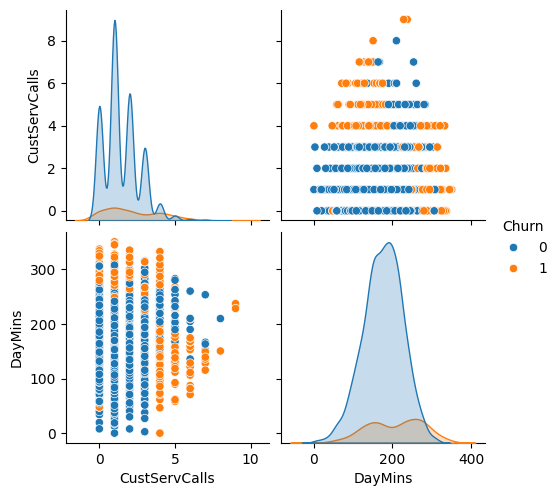

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data[['CustServCalls', 'DayMins', 'Churn']], hue='Churn');

Какие выводы можно отсюда сделать, помните?

Главный вывод, исходя из представленной парной визуализации признаков, заключается в том, что наглядно видно, что для уходящих от нас пользователей есть две ярко выраженные группы:

1. Те, кто мало разговаривают (DayMins маленький), но много звонят в CustomerService
2. Те, кто много разговаривают (DayMins большой), но мало звонят в CustomerService

В общем и целом, на этом и других парных графиках мы можем анализировать взаимодействие трех переменных. Данная информация очень полезна для создания новых признаков (Feature Extraction, Feature Transformation), убирания старых (Feature Selection), выбора алгоритмов; и, конечно, эта информация может и будет использоваться нами в дальнейшем, при последовательной работе над улучшением качества модели.

### Улучшение качества модели

Ну что же, теперь, когда первичная подготовка данных сделана, мы можем переходить непосредственно к усовершенствованию имеющегося у нас пайплайна.

Собственно, для улучшения качества работы и обобщающей способности алгоритмов, выполним следующие этапы:

* Стандартизируем признаки, используя Standard Scaler;
* Снизим размерность в данных с помощью Principal Component Analysis (PCA); судя по предыдущему анализу, мы, вероятно, сможем снизить размерность минимум на 3-5 вообще без потерь;
* Поэкспериментируем с различными гиперпараметрами алгоритмов кластеризации и сравним результаты.

Приступим к реализации этого плана!

Для начала импортируем класс `StandardScaler` из модуля `preprocessing` библиотеки `sklearn`.


In [19]:
from sklearn.preprocessing import StandardScaler

Создаем `StandardScaler` и обучаем его на трейне.

In [20]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train_normed = scaler.transform(X_train)

Отлично, теперь можем переходить к PCA.

В целом, как вы, возможно, заметили, мы здесь, по сути, повторяем пайплайн преобразования датасета, который делали и с KNN, когда впервые работали с этим датасетом: data —> scaled data —> PCA data. Штука, на самом деле, очень универсальная — работает почти с любыми задачами ML и много где помогает существенно улучшить качество.


Импортируем метод `PCA` из модуля `decomposition` библиотеки `sklearn`.


In [21]:
from sklearn.decomposition import PCA

Создаем `PCA` и обучаем его на нормализованном трейне (который получили после преобразования скейлером). Количество главных компонент в `PCA` давайте возьмём равным 7, по аналогии с нашим решением задачи классификации в прошлый раз.


In [22]:
pca = PCA(n_components = 7)
pca.fit(X_train_normed, y_train)

PCA(n_components=7)

Применяем трансформации к данным:


In [23]:
X_train_pca = pca.transform(X_train_normed)

Создадим объект класса `KMeans` с числом кластеров равным 2, а объект класса `DBSCAN` — c параметрами по умолчанию. Обучим алгоритмы на тренировочном датасете и сделаем предсказания на нем же.






In [24]:
kmeans = KMeans(n_clusters=2, random_state=0)
dbscan = DBSCAN()

kmeans.fit(X_train_pca)
dbscan.fit(X_train_pca)

y_kmeans = kmeans.predict(X_train_pca)
y_dbscan = dbscan.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Посмотрим на полученный ответ K-Means: сколько элементов было отнесено к кластеру 0 и сколько элементов — к кластеру 1.


In [25]:
print(f"Элементов в нулевом кластере: {len(y_kmeans[y_kmeans == 0])}, в первом: {len(y_kmeans[y_kmeans == 1])}")

Элементов в нулевом кластере: 1943, в первом: 723


Давайте посмотрим, в каком кластере какой содержится процент класса 1.

In [26]:
print(f"В нулевом кластере находится {len(y_train[(y_kmeans == 0) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В первом кластере находится  {len(y_train[(y_kmeans == 1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")

В нулевом кластере находится 0.8282051282051283 от класса 1
В первом кластере находится  0.1717948717948718 от класса 1


Что можете сказать по результатам?

Мы видим, что теперь большая часть отточных клиентов сосредоточилась в нулевом кластере. Однако, вопреки вашим возможным предположениям, это, к сожалению, показывает лишь то, что структурно мы их все так же плохо отличаем, поскольку сейчас нулевой кластер почти в 2.5 раза больше первого.

Посмотрим теперь на ответы DBSCAN: сколько кластеров выделил он и какие они.

In [27]:
print(f"Число кластеров: {np.unique(y_dbscan)}")

Число кластеров: [-1]


Как можно видеть, DBSCAN по-прежнему не находит какой-либо структуры в данных, но мы не отчаиваемся и сейчас снова попытаемся найти подходящий радиус окрестности подбором гиперпараметров.

Запускаем цикл, как в прошлый раз, и смотрим на результаты:

In [28]:
for eps in np.linspace(0.1, 5, 50):
    dbscan = DBSCAN(eps = eps)
    dbscan.fit(X_train_pca)
    y_dbscan = dbscan.labels_
    if len(np.unique(y_dbscan)) > 1:
        print(eps, len(np.unique(y_dbscan)))

0.6 6
0.7000000000000001 25
0.8 22
0.9 22
1.0 9
1.1 9
1.2000000000000002 6
1.3000000000000003 4
1.4000000000000001 4
1.5000000000000002 5
1.6 3
1.7000000000000002 3
1.8000000000000003 4
1.9000000000000001 2
2.0 2
2.1 2
2.2 2
2.3000000000000003 2
2.4000000000000004 2
2.5000000000000004 2
2.6 2
2.7 2
2.8000000000000003 2
2.9000000000000004 2
3.0000000000000004 2
3.1 2
3.2 2
3.3000000000000003 2
3.4000000000000004 2
3.5000000000000004 2
3.6 2
3.7 2
3.8000000000000003 2
3.9000000000000004 2
4.0 2
4.1 2
4.2 2


Ура, наконец-то победа! Мы получили случаи, отличные от просто шума!

#### Вопрос

Как можно видеть, случаи с `eps` меньше 0.6 и больше 4.2 нам не подходят. Чем отличаются эти случаи: когда меньше 0.6 и когда больше 4.2 — друг от друга?

Вообще, какие выводы вы можете сделать, исходя из полученных результатов?

Давайте теперь рассмотрим конкретный пример гиперпараметра при `eps`, скажем, равном 1.3. Видим, что в таком случае алгоритмом определяется 3 кластера. Давайте их повнимательнее рассмотрим: наша задача — понять, какой процент отточников присутствует внутри каждого из них.

In [29]:
dbscan = DBSCAN(eps = 1.3)
dbscan.fit(X_train_pca)
y_dbscan = dbscan.labels_

In [30]:
print(f"В выбросах ({sum((y_dbscan == -1))}) находится {len(y_train[(y_dbscan == -1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В нулевом ({sum((y_dbscan == 0))}) кластере находится {len(y_train[(y_dbscan == 0) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В первом ({sum((y_dbscan == 1))}) кластере находится {len(y_train[(y_dbscan == 1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"Во втором ({sum((y_dbscan == 2))}) кластере находится {len(y_train[(y_dbscan == 2) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")

В выбросах (429) находится 0.34615384615384615 от класса 1
В нулевом (1700) кластере находится 0.5897435897435898 от класса 1
В первом (531) кластере находится 0.05897435897435897 от класса 1
Во втором (6) кластере находится 0.005128205128205128 от класса 1


Неплохой результат! Какие выводы можно сделать?

Давайте проведем такой же анализ для другого `eps`. Например, для `eps` равного 1.5

In [31]:
dbscan = DBSCAN(eps = 1.5)
dbscan.fit(X_train_pca)
y_dbscan = dbscan.labels_

In [32]:
print(f"В выбросах ({sum((y_dbscan == -1))}) находится {len(y_train[(y_dbscan == -1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В нулевом ({sum((y_dbscan == 0))}) кластере находится {len(y_train[(y_dbscan == 0) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В первом ({sum((y_dbscan == 1))}) кластере находится {len(y_train[(y_dbscan == 1) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"Во втором ({sum((y_dbscan == 2))}) кластере находится {len(y_train[(y_dbscan == 2) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В третьем ({sum((y_dbscan == 3))}) кластере находится {len(y_train[(y_dbscan == 3) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")
print(f"В четвертом ({sum((y_dbscan == 4))}) кластере находится {len(y_train[(y_dbscan == 4) & (y_train == 1)]) / len(y_train[y_train == 1])} от класса 1")

В выбросах (200) находится 0.1794871794871795 от класса 1
В нулевом (1827) кластере находится 0.7076923076923077 от класса 1
В первом (28) кластере находится 0.020512820512820513 от класса 1
Во втором (609) кластере находится 0.09230769230769231 от класса 1
В третьем (2) кластере находится 0.0 от класса 1
В четвертом (0) кластере находится 0.0 от класса 1


Что можно сказать тут?

Сделаем вывод: в наших данных можно выделить структурные кластеры, которые в том числе будут включать в себя большую часть отточных клиентов. Для того чтобы увидеть эти структуры, было бы удобно воспользоваться методами визуализации данных с понижением размерности, такие как SNE/t-SNE или знакомый нам PCA.

В любом случае, дальнейший анализ кластеров предлагается слушателю в качестве самостоятельного упражнения!

## Раздел 2. Многоклассовая классификация

Итак, с кластеризацией мы разобрались, самое время — отдать долг неразобранной теме: многоклассовой классификации.

Для того, чтобы решать задачу многоклассовой классификации, нам нужен датасет. Чтобы не тратить время на предобработку данных, воспользуемся известным датасетом в ирисами Фишера. Он есть даже в ряде библиотек.

In [33]:
# Загрузим датасет iris из библиотеки seaborn
df_iris = sns.load_dataset("iris")
df_iris = df_iris.sample(n=150)
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
117,7.7,3.8,6.7,2.2,virginica
133,6.3,2.8,5.1,1.5,virginica
118,7.7,2.6,6.9,2.3,virginica
15,5.7,4.4,1.5,0.4,setosa
25,5.0,3.0,1.6,0.2,setosa


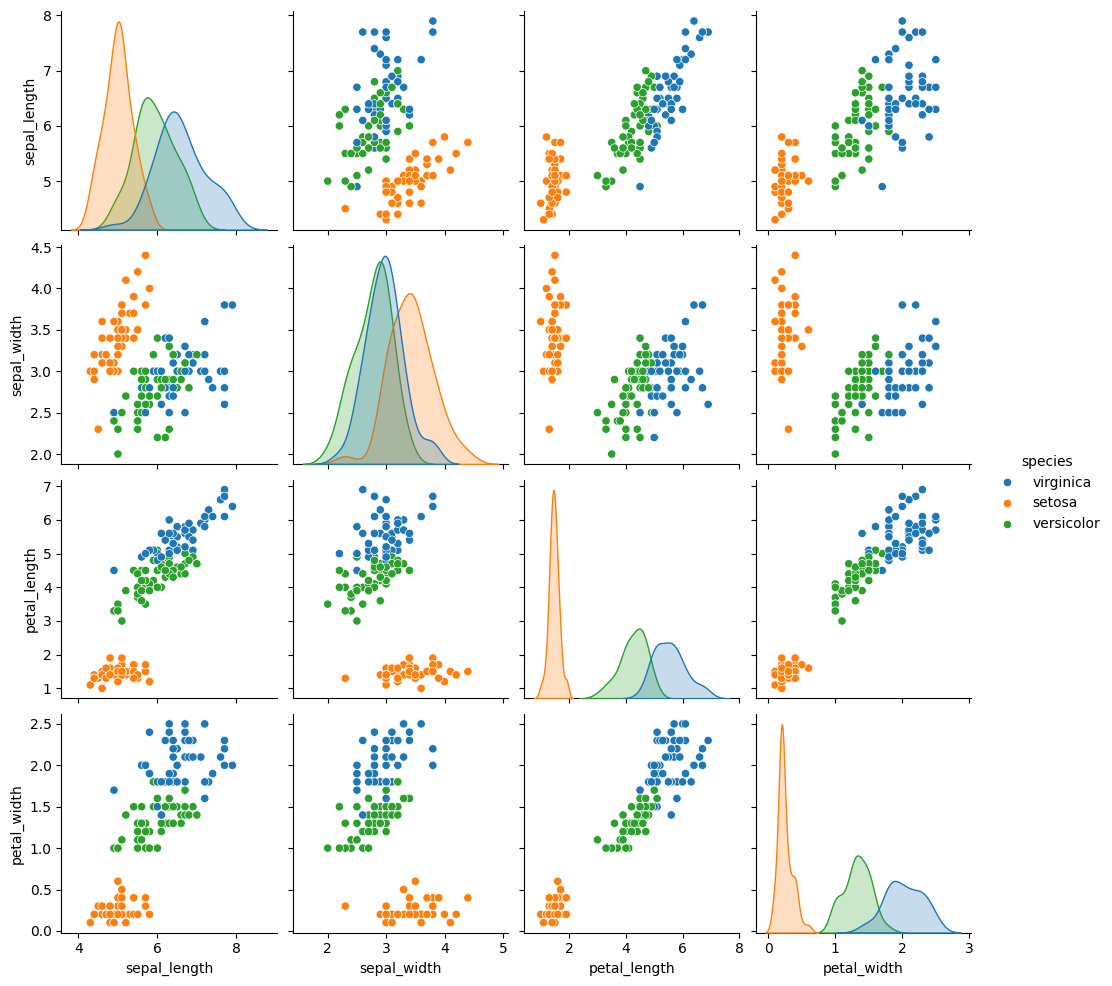

In [34]:
#Построим pairplot
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.pairplot(df_iris, hue="species")

In [35]:
# закодируем категориальные столбцы label-энкодером
from sklearn.preprocessing import LabelEncoder

# Создадим объект класса LabelEncoder
enc = LabelEncoder()

# Обучим его на столбце species
enc.fit(df_iris['species'])

# Трансформируем этот столбец при помощи метода transform
df_iris['species'] = enc.transform(df_iris['species'])

In [36]:
# Разделим данные на признаки и таргет
iris_X = df_iris.drop(columns=['species'])
iris_y = df_iris['species']


# Разделим данные на обучене и тест (как и раньше со стратификацией по таргету) (возьмем test_size=0.9, чтобы были хоть какие-то ошибки)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y, test_size=0.9, stratify = iris_y)

In [37]:
from sklearn.linear_model import LogisticRegression

# Обучим логистическую регрессию
iris_log_reg = LogisticRegression().fit(iris_X_train, iris_y_train)

In [38]:
# Сделаем предсказания
iris_y_log_reg = iris_log_reg.predict(iris_X_test)

iris_y_log_reg_proba = iris_log_reg.predict_proba(iris_X_test)

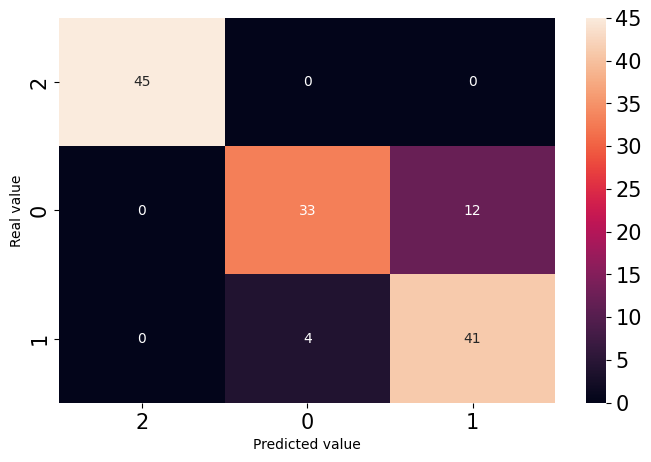

In [41]:
from sklearn.metrics import confusion_matrix

# Построим матрицу ошибок, чтобы понять как справляется наш алгоритм
mp_mtx = confusion_matrix(iris_y_test, iris_y_log_reg)

fig = plt.figure(figsize=(8,5))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d",
            xticklabels=df_iris["species"].unique(),
            yticklabels=df_iris["species"].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")
plt.show()

Нам бы хотелось пользоваться такими же метриками, как и при бинарной классификации, но поскольку у нас большее число классов, нам нужно как-то считать метрики в бинарном случае и потом их усреднять. На этой идее и строятся два основных подхода подсчета:
- `macro` — подсчет метрик в биноризированном случае и их дальнейшее усреднение
- `micro` — подсчет TP, TN, FP, FN для каждого класса в бинарном случае, а затем использование их суммы в соответствующих формулах метрик.

Рассчитаем руками macro и micro precision для матрицы ошибок в нашей задаче.

In [42]:
from sklearn.metrics import precision_score

# Проверим себя
print(f"MACRO PRECISION: {precision_score(iris_y_test, iris_y_log_reg, average='macro')}")
print(f"MICRO PRECISION: {precision_score(iris_y_test, iris_y_log_reg, average='micro')}")

MACRO PRECISION: 0.8884922658507565
MICRO PRECISION: 0.8814814814814815


Можем посчитать и другие метрики если вы еще живы:)

**Но общая идея использования следующая:**  
При подсчете `Macro Average` мы  теряем информацию о кол-ве наблюдений, поэтому ее лучше `не использовать при дисбалансе` классов.

*Например* у нас есть 4 класса. У первых трех precision равняется 0.9, а у четвертого 0.4. При этом в первых трех классах по 100 наблюдений, а в четвертом 10000. `Macro Average` будет высокой 77, 5%, хотя модель нельзя назвать хорошей. `Micro Average` в таком случае будет значительно ниже.


Но что делать с `ROC-AUC`?

Для него не посчитать `Micro Average` (почему?), остается только `Macro Average`, но даже с ним есть проблемы -- как считать вероятности?

Первый вариант:

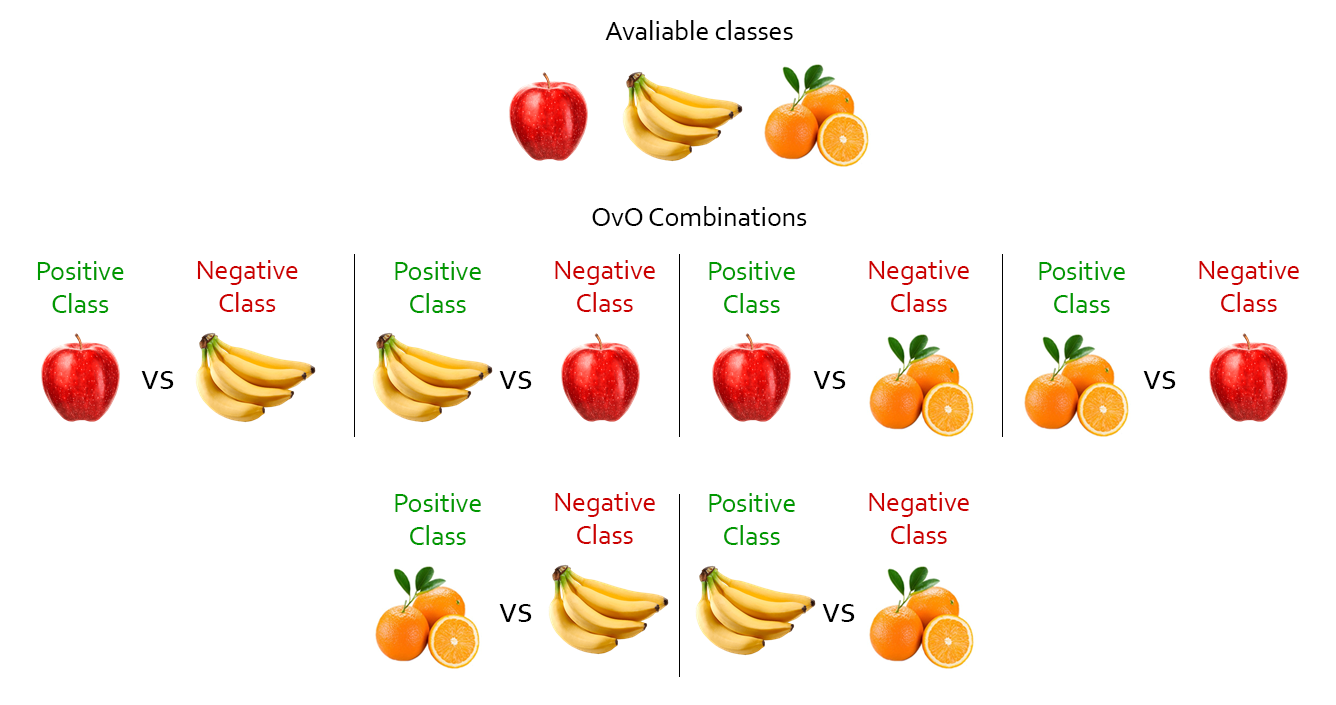

Второй вариант:

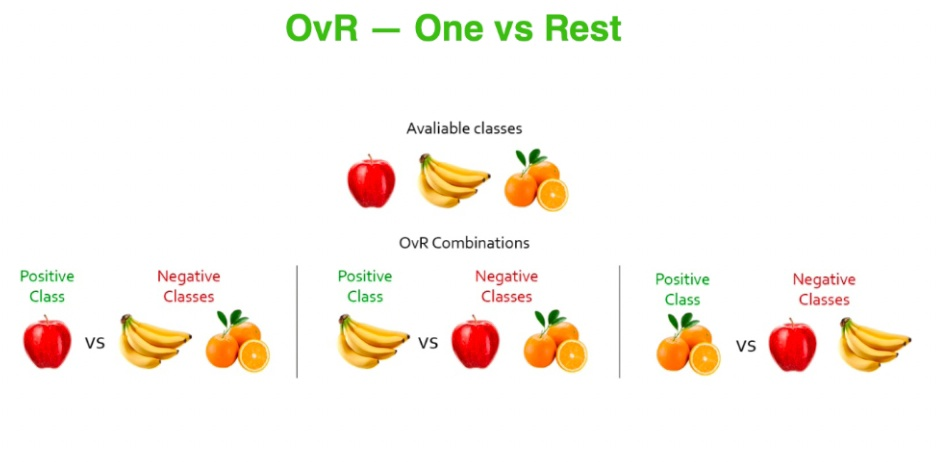

In [43]:
from sklearn.metrics import roc_auc_score

# Рассчитаем ROC-AUC разными стратегиями

print(f"OvO: {roc_auc_score(iris_y_test, iris_y_log_reg_proba, multi_class='ovo')}")
print(f"OvR: {roc_auc_score(iris_y_test, iris_y_log_reg_proba, multi_class='ovr')}")

OvO: 0.9747325102880658
OvR: 0.9747325102880658


Если говорить совсем честно, то у метрик параметр `average` принимает также значения `'weighted'` и `None`. Как вы думаете, что происходит при таких значениях параметра?

Вот мы и обсудили все, что нужно знать на первое время по многоклассовой классификации. Но помните: у нас была задача и по ней мы только построили бейзлайн. Вернемся к ней и будем улучшать?